In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci

In [2]:
df = pd.read_csv("input data/XRPUSDT_1m.csv")
df

,Unnamed: 0,timestamp,open,high,low,close,volume
0,0,2022-08-27 16:00:00,0.3341,0.3347,0.3338,0.3345,415512.0
1,1,2022-08-27 16:01:00,0.3346,0.3347,0.3342,0.3343,301784.0
2,2,2022-08-27 16:02:00,0.3343,0.3343,0.3340,0.3342,280526.0
3,3,2022-08-27 16:03:00,0.3342,0.3344,0.3338,0.3339,242849.0
4,4,2022-08-27 16:04:00,0.3340,0.3346,0.3340,0.3346,119194.0
...,...,...,...,...,...,...,...
524995,524995,2023-08-27 07:15:00,0.5266,0.5266,0.5265,0.5265,15949.0
524996,524996,2023-08-27 07:16:00,0.5265,0.5266,0.5261,0.5261,60825.0
524997,524997,2023-08-27 07:17:00,0.5261,0.5263,0.5260,0.5262,54715.0
524998,524998,2023-08-27 07:18:00,0.5263,0.5264,0.5263,0.5264,79429.0


In [3]:
price_array = np.array([])
L = len(df.index)
for t in range(L) :
    '''if t%(L//100)== 0:
        print(t)'''
    price_array = np.append(price_array , (df.loc[t , "open" ]+df.loc[t , "close" ])/2)

log_price_array = np.log(price_array)
r_array = np.diff( log_price_array)

time = np.array([df.loc[t,'timestamp'] for t in range( len(df['timestamp']) ) ])

### Compute truncated Levy distribution (TLD)
Given $\alpha>0$, TLD behaves like Pareto distribution(symmetry stable) in the region $x<<\frac{1}{\alpha}$ and
outside of the region it decays exponentially fast. It's c.f is given by:
$$
\hat{L}^{(t)}_\mu(z) = exp\big[ 
-a_\mu \frac{ (\alpha^2 + z^2)^\frac{\mu}{2} \cos(\mu \arctan(\lvert z\rvert/\alpha))}{\cos(\pi\mu/2)}
\big]
$$
where 
$$
a_\mu =
\begin{cases}
\mu \Gamma(\mu-1) \frac{\sin(\pi\mu/2)}{A\pi} &\text{if} \quad 1<\mu<2 \\
(1-\mu) \Gamma(\mu) \frac{\sin(\pi\mu/2)}{A\pi} &\text{if} \quad \mu<1
\end{cases}
$$
for some tail parameter $A>0$. We can use inverse Fourier transform to compute the pdf.

In [2]:
from scipy.integrate import quad

# 定義a_mu係數的值
def a_mu_constant(A,mu):
    if mu>1 :
        return A**mu * np.pi / (mu * sci.special.gamma(mu-1) * np.sin(np.pi * mu/2))
    if mu<1 :
        return A**mu * np.pi * mu / ((1-mu) * sci.special.gamma(mu) * np.sin(np.pi * mu/2))

# 定義TLD的傅立葉轉換 abs(x)<< 1/alpha: Levy abs(x)>1/alpha : exponential decay
def inverse_fourier_integrand(z, x, A, mu,alpha):
    return np.exp(-1j * x * z) * np.exp(-a_mu_constant(A,mu) * ((alpha**2 + z**2)**(mu/2) *
                                                                np.cos(mu * np.arctan(abs(z) / alpha)) - alpha**mu) / np.cos(np.pi * mu/2))


# 定義傅立葉反轉換來計算TLD的PDF
def TLD_pdf(x, A, mu, alpha):
  # 進行積分
    TLDpdf=[]
    for t in x:
        result, error = quad(lambda z: inverse_fourier_integrand(z, t, A, mu, alpha).real, -np.inf, np.inf)
        TLDpdf.append(result / (2 * np.pi))
    return TLDpdf

#or replace the part outside 2/alpha with some power law multiply exponential decay , the result is almost the same
# def TLD_pdf(x, A, mu, alpha):
#   # 進行積分
#     TLDpdf=[]
#     for t in x:
#         if -2/alpha < t < 2/alpha :
#             result, error = quad(lambda z: inverse_fourier_integrand(z, t, A, mu, alpha).real, -np.inf, np.inf)
#             TLDpdf.append(result / (2 * np.pi))
#         else:
#             TLDpdf.append(a_mu_constant(A,mu) * sci.special.gamma(mu+1) * np.sin(np.pi*mu/2) * np.exp(-alpha*abs(t)) / (np.pi*abs(t)**(1+mu)))
#     return TLDpdf

#### Compare different $A$

C:\Users\std92\AppData\Local\Temp\ipykernel_7588\3115813422.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(lambda z: inverse_fourier_integrand(z, t, A, mu, alpha), -np.inf, np.inf)
C:\Users\std92\AppData\Local\Temp\ipykernel_7588\3115813422.py:21: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(lambda z: inverse_fourier_integrand(z, t, A, mu, alpha), -np.inf, np.inf)


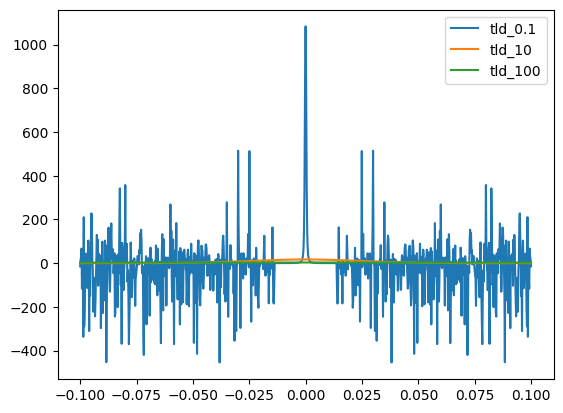

In [374]:
x = np.linspace(-0.1,0.1,1000)
for i in [0.1,10,100]:
    plt.plot(x,TLD_pdf(x, A=0.0018*i, mu=1.5, alpha=50),label=f'tld_{i}')
plt.legend()

A=0.00018 leads to computation error

#### Compare different $\alpha$

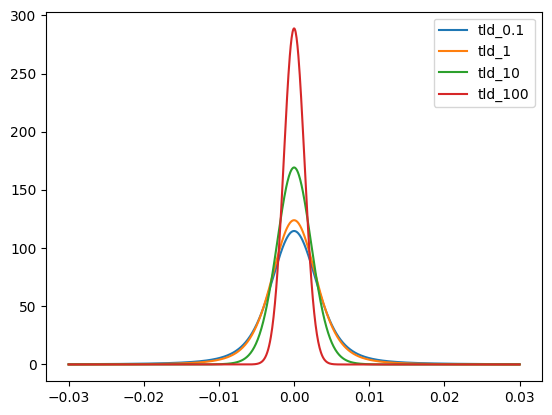

In [210]:
for i in [0.1,1,10,100]:
    plt.plot(x,TLD_pdf(x, A=0.0018, mu=1.5, alpha=50*i),label=f'tld_{i}')
plt.legend()

#### Compare different $\mu$

C:\Users\std92\AppData\Local\Temp\ipykernel_7588\2612199876.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(lambda z: inverse_fourier_integrand(z, t, A, mu, alpha).real, -np.inf, np.inf)


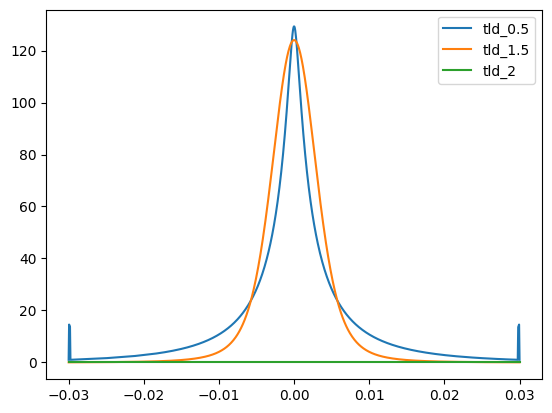

In [207]:
for i in [0.5,1.5,2]:
    plt.plot(x,TLD_pdf(x, A=0.0018, mu=i, alpha=50),label=f'tld_{i}')
plt.legend()

### Empirical inverse CDF(1-cdf , log-log plot)

We consider 1 min and 30min interval datas. First we try to fit their empirical distribution (1-cdf) with  normal and t distribution.

In [ ]:
def cdf(x_array,pdf_array):
    cdf_array = np.zeros_like(pdf_array)
    S=0
    d = x_array[1]-x_array[0]
    for i in range(len(pdf_array)):
        S+=pdf_array[i]*d
        cdf_array[i]=S
    return cdf_array

Too avoid the computation error for TLD with small $A$, we multiply the return array by $100$ ($x \% \to x$).

#### 1 min

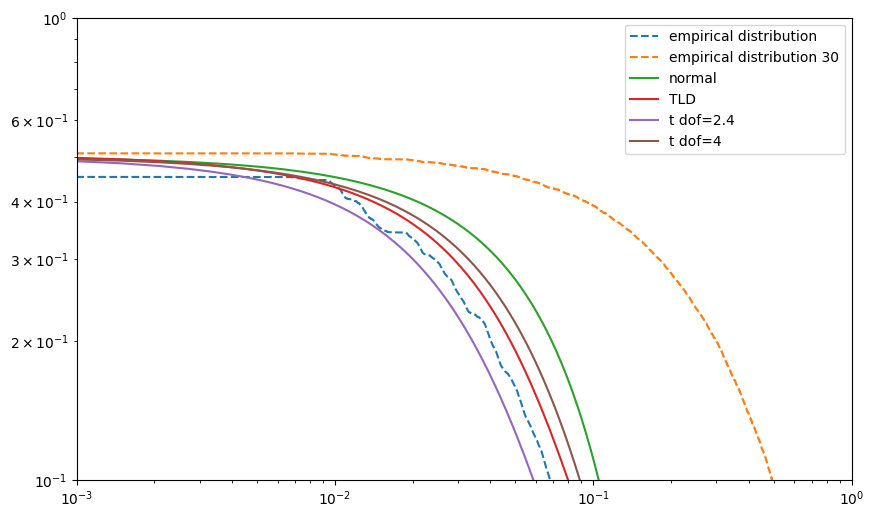

In [460]:
sigma=np.std(100*r_array)
mu = np.mean(100*r_array)

x_array = np.linspace(-0.3,0.3,1000)
TLD = TLD_pdf(x_array, A=sigma/4, mu=1.5, alpha=1)
TLD_cdf = cdf(x_array,TLD)

plt.figure(figsize=(10,6))
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-3),1)
plt.ylim(10**(-1),1)
plt.ecdf(100*r_array,complementary=True,ls='--',label='empirical distribution')
plt.ecdf(100*r_array30,complementary=True,ls='--',label='empirical distribution 30')
plt.plot(x_array,1-sci.stats.norm.cdf(x_array,mu,sigma),label='normal')

plt.plot(x_array,1-TLD_cdf,label='TLD')
plt.plot(x_array,1-sci.stats.t.cdf(x_array, 2.4, 0,sigma*np.sqrt( (2.4-2)/2.4 )),label='t dof=2.4')
plt.plot(x_array,1-sci.stats.t.cdf(x_array, 4, 0,sigma*np.sqrt( (4-2)/4 )),label='t dof=4')
plt.legend()

#### 30 min

In [ ]:
price_array30 = np.array([])
L = len(df.index)
for t in range(0,L,30) :
    '''if t%(L//100)== 0:
        print(t)'''
    price_array30 = np.append(price_array30 , (df.loc[t , "open" ]+df.loc[t , "close" ])/2)

log_price_array30 = np.log(price_array30)
r_array30 = np.diff( log_price_array30)

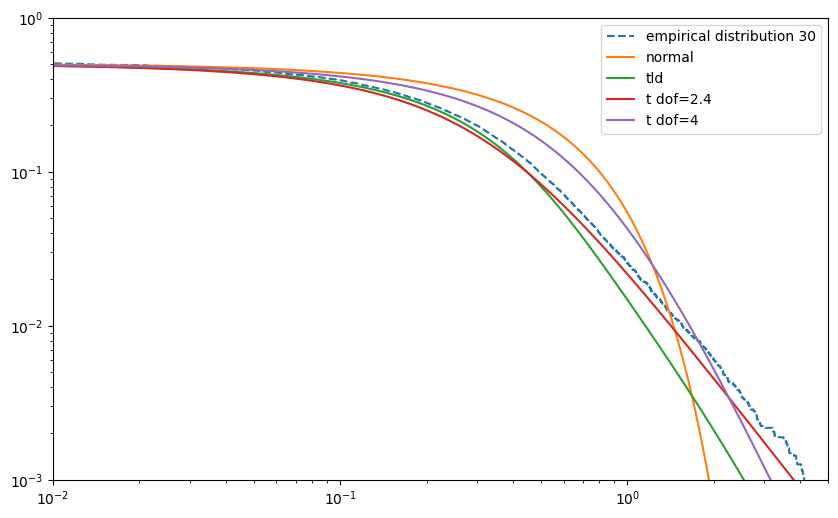

In [461]:
x_array30 = np.linspace(-5,5,10000)
sigma30=np.std(100*r_array30)
mu30 = np.mean(100*r_array30)
TLD30 = TLD_pdf(x_array30, A=sigma30/3.5, mu=1.5, alpha=1/2)
TLD_30_cdf = cdf(x_array30,TLD30)

plt.figure(figsize=(10,6))
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-2),5)
plt.ylim(10**(-3),1)
plt.ecdf(100*r_array30,complementary=True,ls='--',label='empirical distribution 30')
plt.plot(x_array30,1-sci.stats.norm.cdf(x_array30,mu30,sigma30),label='normal')
plt.plot(x_array30,1-TLD_30_cdf,label='tld')
plt.plot(x_array30,1-sci.stats.t.cdf(x_array30, 2.4, 0,sigma30*np.sqrt( (2.4-2)/2.4 )),label='t dof=2.4')
plt.plot(x_array30,1-sci.stats.t.cdf(x_array30, 4, 0,sigma30*np.sqrt( (4-2)/4 )),label='t dof=4')

plt.legend()

### Empirical pdf 

#### 1 min interval

(0.0, 4.0)

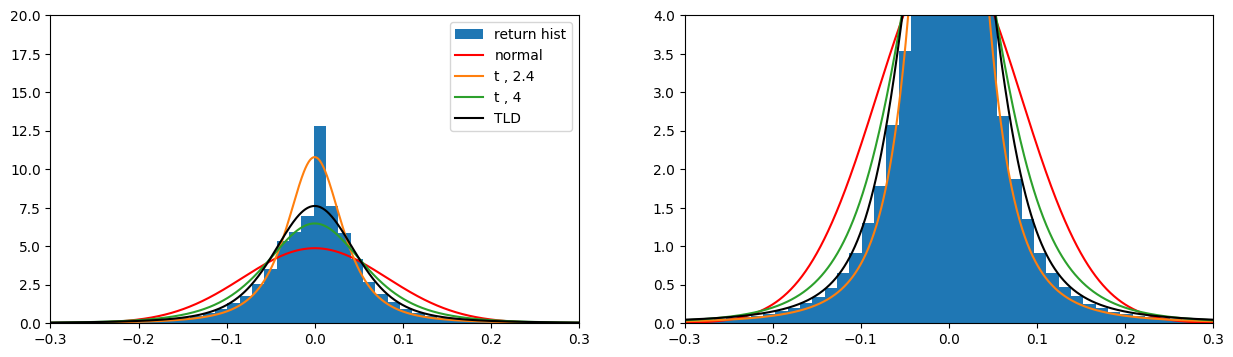

In [462]:

fig,ax=plt.subplots(1,2,figsize=(15,4))
ax[0].hist(100*r_array,bins=1000,density=True,label="return hist")
normal = sci.stats.norm.pdf(x_array,mu,sigma)
t_2 = sci.stats.t.pdf(x_array, 2.4, 0,sigma*np.sqrt( (2.4-2)/2.4 ))
t_4 = sci.stats.t.pdf(x_array, 4, 0,sigma*np.sqrt( (4-2)/4 ))
ax[0].plot(x_array,normal,color='r',label="normal")
ax[0].plot(x_array, t_2, label='t , 2.4')
ax[0].plot(x_array, t_4, label='t , 4')
ax[0].plot(x_array, TLD, label='TLD',color='black')

ax[0].legend()
ax[0].set_xlim(-0.3,0.3)
ax[0].set_ylim(0,20)

ax[1].hist(100*r_array,bins=1000,density=True,label="return hist")
ax[1].plot(x_array,normal,color='r',label="normal")
ax[1].plot(x_array, t_2, label='t , 2.4')
ax[1].plot(x_array, t_4, label='t , 4')
ax[1].plot(x_array, TLD, label='TLD',color='black')
ax[1].set_xlim(-0.3,0.3)
ax[1].set_ylim(0,4)

#### 30 min interval

In [475]:

normal = sci.stats.norm.pdf(x_array30,mu30,sigma30)
t_2 = sci.stats.t.pdf(x_array30, 2.4, 0,sigma30*np.sqrt( (2.4-2)/2.4 ))
t_4 = sci.stats.t.pdf(x_array30, 4, 0,sigma30*np.sqrt( (4-2)/4 ))

TLD30_2 = TLD_pdf(x_array30, A=sigma30/3.5, mu=1.5, alpha=1/2)


In [495]:
TLD30_3 = TLD_pdf(x_array30, A=sigma30/3, mu=1.5, alpha=1/4)
TLD30_1 = TLD_pdf(x_array30, A=sigma30/3, mu=1.45, alpha=1/4)
TLD30_12 = TLD_pdf(x_array30, A=sigma30/3.5, mu=1.45, alpha=1/4)

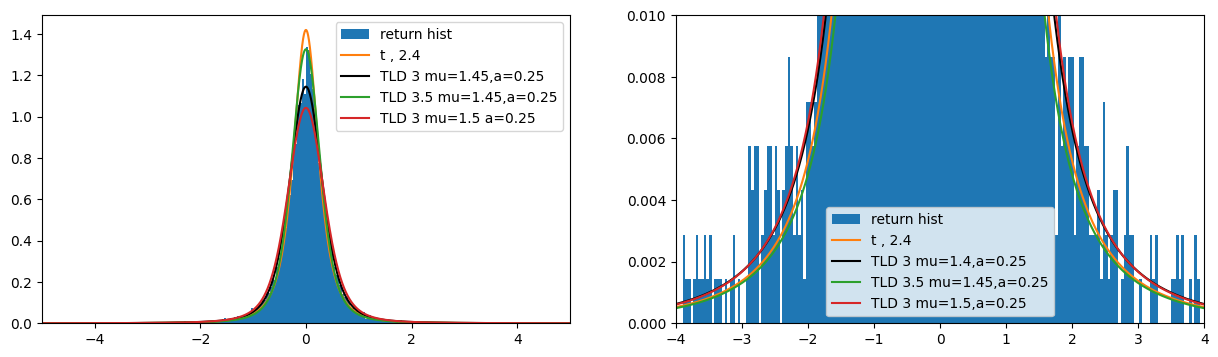

In [497]:
fig,ax=plt.subplots(1,2,figsize=(15,4))
ax[0].hist(100*r_array30,bins=1000,density=True,label="return hist")
#ax[0].plot(x_array30,normal,color='r',label="normal")
ax[0].plot(x_array30, t_2, label='t , 2.4')
#ax[0].plot(x_array30, t_4, label='t , 4')
ax[0].plot(x_array30, TLD30_1, label='TLD 3 mu=1.45,a=0.25',color='black')
ax[0].plot(x_array30, TLD30_12, label='TLD 3.5 mu=1.45,a=0.25')
#ax[0].plot(x_array30, TLD30_2, label='TLD a=0.25')
ax[0].plot(x_array30, TLD30_3, label='TLD 3 mu=1.5 a=0.25')

ax[0].legend()
ax[0].set_xlim(-5,5)

ax[1].hist(100*r_array30,bins=1000,density=True,label="return hist")
#ax[1].plot(x_array30,normal,color='r',label="normal")
ax[1].plot(x_array30, t_2, label='t , 2.4')
#ax[1].plot(x_array30, t_4, label='t , 4')
ax[1].plot(x_array30, TLD30_1, label='TLD 3 mu=1.4,a=0.25',color='black')
ax[1].plot(x_array30, TLD30_12, label='TLD 3.5 mu=1.45,a=0.25')
#ax[1].plot(x_array30, TLD30_2, label='TLD a=0.5')
ax[1].plot(x_array30, TLD30_3, label='TLD 3 mu=1.5,a=0.25')
ax[1].set_xlim(-4,4)
ax[1].set_ylim(0,0.01)
ax[1].legend()



For 30min TLD, $A=\frac{\sigma}{3}$ , $\mu = 1.45 $ , $\alpha=0.25$ sholud be better?